![](Images/OCL-Khronos.png)

---

<img src='Images/HP-Python-X.png' align='left' style='margin:10px 30px'>
<div style='margin:30px 0px 0px 10px'>
<h2>High Performance Python</h2>
<p>Practical Performant Programming for Humans</p>
<p>Micha Gorelick and Ian Ozsvald 
<br/>O'Reilly (2014)</p>
</div>

<h2>OpenCL Books</h2>
<div style='margin:30px 0px 0px 10px'>
<h3>OpenCL Programming by Example</h3>
<p>Ravishekhar Banger and Koushik Bhattacharyya, Packt (2013)</p>
</div>

<div style='margin:30px 0px 0px 10px'>
<h3>OpenCL Parallel Programming Development Cookbook</h3>
<p>Raymond Tay, Packt (2013)</p>
</div>

<div style='margin:30px 0px 0px 10px'>
<h3>OpenCL in Action</h3>
<p>Matthew Scarpino, Manning (2012)</p>
</div>

<hr/>

<h2>CUDA Books</h2>
<div style='margin:30px 0px 0px 10px'>
<h3>CUDA Programming</h3>
<p>Shane Cook, Elsevier (2013)</p>
</div>

<div style='margin:30px 0px 0px 10px'>
<h3>CUDA for Engineers</h3>
<p>Duane Storti and Mete Yurtoglu, Addison-Wesley (2015)</p>
</div>

<hr/>

![](Images/APsX.png)

## GPU Timeline

- 1992 OpenGL (SGI / Khronos)
- 1995 DirectX (Microsoft)
- 2003 OpenGL ES (Khronos)
- 2007 CUDA (NVidia)
- 2009 OpenCL (Apple / Khronos)
<br/><br/>
- 2011 WebGL (Khronos)
- 2014 SPIR (Khronos)
- 2016 Vulkan (Khronos)

---

<img src='Images/ak-pic.png' align='left'>
<h2>&nbsp;&nbsp;&nbsp;Andreas Kl&#246;ckner</h2>
<h3>&nbsp;&nbsp;&nbsp;&nbsp;University of Illinois Urbana-Champaign</h3>
<br/><br/>
- [Andreas Klöckner - Software Page](https://mathema.tician.de/software/)
- [Andreas Klöckner - Wiki](https://wiki.tiker.net)
- [Andreas Klöckner - Github](https://github.com/inducer)
<br/><br/>
- [PyCUDA documentation](https://documen.tician.de/pycuda/)
- [PyOpenCL documentation](https://documen.tician.de/pyopencl/)


![](Images/ak-software.png)

![](Images/Demo-Time.png)

In [2]:
#
# Import PyOpenCL and Numpy
#
import time as tm

import numpy as np
import numpy.random as nr

import pyopencl as cl
import pyopencl.array as cla

In [4]:
# Importing PyOpenCL populates some data structures 
#
plat = cl.get_platforms()
print "\nPlatform: %s" % plat[0].name

for dev in plat[0].get_devices():
    print "Device: %s" % dev.name
        


Platform: Apple
Device: Intel(R) Core(TM) i5-4258U CPU @ 2.40GHz
Device: Iris


---

## Lenovo IdeaPad Z50-70: 
<img src='Images/Lenovo5070X.png' align='right' />

### Intel(R) OpenCL
    - Intel(R) Core(TM) i7-4510U CPU @ 2.00GHz
    - Intel(R) HD Graphics 4400
	
### NVIDIA Cuda
	- GeForce 840M
	
### Experimental OpenCL 2.0 CPU Only Plaform
	- Intel(R) Core(TM) i7-4510U CPU @ 2.00GHz

---

## Hello World ( SAXPY )
<p style="font-size:150%">W[i] = a &#183; X[i] + Y[i] &nbsp;&nbsp; where X, Y ~ $\mathcal{N}$(0.0,1.0)</p>
<p style="font-size:150%">mean(W) = 0 &nbsp; &amp; &nbsp; var(W) = a<sup>2</sup></p>
<br/>


## Benchmark ( SGEMM )
<p style="font-size:150%">W[i] = a &#183; X[i] &#183; Y[i] + b &#183; Z[i] &nbsp;&nbsp; where X, Y, Z ~ $\mathcal{N}$(0.0,1.0)</p>

<p style="font-size:150%">mean(W) = 0 &nbsp; &amp; &nbsp; var(W) = a<sup>2</sup> + b<sup>2</sup></p>

<br/>


In [3]:
# 
# Set parameters and generate some random numbers
#
n = 1000000
a = 1.5
b = 2.5

x = nr.randn(n)
y = nr.randn(n)
z = nr.randn(n)
w = np.zeros(n)

print "\nActual variance is %8.5f\n" % (a*a + b*b)


Actual variance is  8.50000



In [4]:
# Compute using 'native' Python
#
tic = tm.time()
for i in range(n):
    w[i] = a*x[i]*y[i] + b*z[i]

toc = tm.time()

print "DGEMM : Native Python\n-----"
print "Time taken: %8.5f sec." % (toc - tic)
print "Mean      = %8.5f" % np.mean(w)
print "Variance  = %8.5f" % np.var(w)


DGEMM : Native Python
-----
Time taken:  0.86476 sec.
Mean      = -0.00333
Variance  =  8.46704


---

In [5]:
# Compute using the Gpu
# First create a 'context' and start a queue
#
ctx = cl.create_some_context(interactive=True)
queue = cl.CommandQueue(ctx)

# Compile the OpenCL Kernel
#
prg = cl.Program(ctx, """
    __kernel void dgemm(const float a,
                        const float b,
                        __global const float *x,
                        __global const float *y,
                        __global const float *z,
                        __global float *w)
    {
       int gid = get_global_id(0);
       w[gid] = a*x[gid]*y[gid] + b*z[gid];
    }
""").build()

In [8]:
# Generate (32-bit) random numbers and transfer hots -> device.
# Also create space on the device for the results.
#
aa = np.float32(a)
bb = np.float32(b)

x_host = np.random.randn(n).astype(np.float32)
x = cla.to_device(queue, x_host)

y_host = np.random.randn(n).astype(np.float32)
y = cla.to_device(queue, y_host)

z_host = np.random.randn(n).astype(np.float32)
z = cla.to_device(queue, z_host)

w = cla.empty_like(x)

In [9]:
# Run the kernel and return stats.
tic = tm.time()
event = prg.dgemm(queue, (n,), None, aa, bb, x.data, y.data, z.data, w.data)
event.wait()
toc = tm.time()

print "DGEMM : PyOpenCL\n-----"
print "Time taken: %8.5f sec." % (toc - tic)
print "Mean      = %8.5f" % np.mean(w.get())
print "Variance  = %8.5f" % np.var(w.get())
print "\n\n"

DGEMM : PyOpenCL
-----
Time taken:  0.00277 sec.
Mean      = -0.00157
Variance  =  8.47222





In [ ]:
# Three procedures for the Mandelbrotset
# Serial (native) Python
#
def calc_fractal_serial(q, maxiter):
    z = np.zeros(q.shape, complex)
    output = np.resize(np.array(0,), q.shape)
    for i in range(len(q)):
        for iter in range(maxiter):
            z[i] = z[i]*z[i] + q[i]
            if abs(z[i]) > 2.0:
                output[i] = iter
                break
    return output
    
# Using Numpy (for the calcs)
#
def calc_fractal_numpy(q, maxiter):
    output = np.resize(np.array(0,), q.shape)
    z = np.zeros(q.shape, np.complex64)
    for it in range(maxiter):
        z = z*z + q
        done = np.greater(abs(z), 2.0)
        q = np.where(done, 0+0j, q)
        z = np.where(done, 0+0j, z)
        output = np.where(done, it, output)
    return output
    

In [1]:
# Using OpenCL
#
def calc_fractal_opencl(q, maxiter):
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)
    output = np.empty(q.shape, dtype=np.uint16)
    mf = cl.mem_flags
    q_opencl = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=q)
    output_opencl = cl.Buffer(ctx, mf.WRITE_ONLY, output.nbytes)
    prg = cl.Program(ctx, """
    #pragma OPENCL EXTENSION cl_khr_byte_addressable_store : enable
    __kernel void mandelbrot(__global float2 *q,
                     		 __global ushort *output, 
                     		 ushort const maxiter)
    {
        int gid = get_global_id(0);
        float nreal, real = 0;
        float imag = 0;
        output[gid] = 0;
        for(int curiter = 0; curiter < maxiter; curiter++) {
            nreal = real*real - imag*imag + q[gid].x;
            imag = 2* real*imag + q[gid].y;
            real = nreal;
            if (real*real + imag*imag > 4.0f) output[gid] = curiter;
        }
    }
    """).build()
    prg.mandelbrot(queue, output.shape, None, q_opencl,
                   output_opencl, np.uint16(maxiter))
    cl.enqueue_copy(queue, output, output_opencl).wait()
    return output

In [4]:
# Run the serial procedure
#
w = 1024; h = 1024;
x1 = -2.13; x2 = 0.77; y1 = -1.3; y2 = 1.3;

xx = np.arange(x1, x2, (x2-x1)/w);
yy = np.arange(y2, y1, (y1-y2)/h) * 1j;
q = np.ravel(xx+yy[:, np.newaxis]).astype(np.complex64);

tic = tm.time();
mb1 = calc_fractal_serial(q, 30);
toc = tm.time();
print"Serial took: %8.5f" % (toc - tic)


Serial took:  9.54314


In [7]:
# Run the numpy procedure
#
tic = tm.time();
mb2 = calc_fractal_numpy(q, 30);
toc = tm.time();
print"Numpy took: %8.5f" % (toc - tic)


Numpy took:  0.86844


In [11]:
# Run the opencl procedure
#
tic = tm.time();
mb3 = calc_fractal_opencl(q, 30);
toc = tm.time();
print "OpenCL took: %8.5f" % (toc - tic)

OpenCL took:  0.01811


---

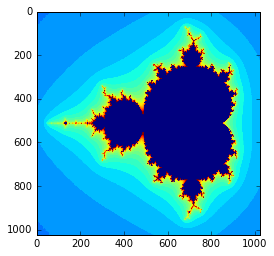

In [12]:
# Plot (one of) the Mandelbrot sets.
#
%matplotlib inline
import matplotlib.pyplot as plt
mandel = (mb3.reshape((h, w)) / float(mb3.max()) * 255.0).astype(np.uint8);
plt.imshow(mandel)


---

## CUDA vs OpenCL ?

### CUDA

- Likely to be working with NVidia kit in Enterprise
- OpenCL will be slower than CUDA on NVidia GPUs
- Large set of online resources / developers area
- Wide variety of CUDA libraries
- C++ templates using "Thrust"
- OpenACC directives

[NVidia Developer's Zone](https://developer.nvidia.com/cuda-zone)<br/>


### OpenCL

- Works with wide variety of hardware
- Can get started with standard kit
- Work in progress on JIT support (POCL)
- Khronos have ambitious roadmap
- Code can be executed on CPU, GPU, DSP, FPGA

[Khronos OpenCL Page](https://www.khronos.org/opencl)<br/>
<p>&nbsp;</p>

[CUDA vs OpenCL](https://wiki.tiker.net/CudaVsOpenCL)

![](images/AK-cuda-opencl.png)

---

![](Images/khronos-timeline.png)


---

![](Images/khronos-connections.png)